# Exploring Content-Based Recommendation Systems in Bipartite Graphs

This notebook investigates content-based recommendation systems within bipartite graphs. These systems utilize object similarity to predict unobserved edges, offering the potential for improved recommendation accuracy and an enhanced user experience. We explore the fundamentals of this approach, where object attributes and relationships are leveraged to create tailored suggestions. Central to our investigation is the assumption of similarity between objects, which forms the bedrock for predicting associations. By estimating unobserved connections through observed ones, we highlight the effectiveness of this method and its significance in the landscape of personalization and content consumption. This work sheds light on the mechanisms underpinning content-based recommendation systems and their potential to redefine user interactions with digital content.


In [38]:
# In this notebook, we will try to estimate the objective function of
# two complex attributes. Each attribute should be embedded before
# being used in the objective function. 
# Finally, we will test that given one attribute, find the other one
# such that the objective function is maximized.

In [39]:
# good reference:
# How to estimate other attributes given one attribute
# https://stackoverflow.com/a/43402975/5441945
# https://keras.io/examples/vision/visualizing_what_convnets_learn/

In [40]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tqdm.auto import tqdm
import matplotlib.pyplot as plt


In [41]:
# load a dataset from internet
from ucimlrepo import fetch_ucirepo

# fetch dataset 
abalone = fetch_ucirepo(id=1)

# data (as pandas dataframes) 

X = abalone.data.features.to_numpy()
abalone.data.features.describe()

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000


In [42]:
rng = np.random.default_rng(12345)

In [43]:
attr1 = X[:, 1:4].astype(np.float32)
attr2 = X[:, 4:8].astype(np.float32)
attr1_dimension = attr1.shape[1]
attr2_dimension = attr2.shape[1]

In [44]:
# # hack attr1 and attr2 as meshgrid from 0 to 1 and preserve the original shape
# attr1 = rng.random((100000, attr1_dimension)) * (attr1.max(axis=0)-attr1.min(axis=0)) + attr1.min(axis=0)
# attr2 = rng.random((100000, attr2_dimension)) * (attr2.max(axis=0)-attr2.min(axis=0)) + attr2.min(axis=0)

In [45]:
pd.DataFrame(attr1).describe()

,0,1,2
count,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516
std,0.120093,0.099240,0.041827
min,0.075000,0.055000,0.000000
25%,0.450000,0.350000,0.115000
50%,0.545000,0.425000,0.140000
75%,0.615000,0.480000,0.165000
max,0.815000,0.650000,1.130000


In [46]:
def real_objective(arr1, arr2):
    # return a complex arbitrary function of arr1 and arr2
    # quadratic term with maximum at attr2 = [1.3, 0.7, 0.4, 0.5]
    quadratic_term = (arr2[:,0]-1.3)**2 + 5*(arr2[:,0]-1.3)**4 + 2*(arr2[:,1]-0.7)**2 + 6*(arr2[:,2]-0.4)**2 + 8*(arr2[:,3]-0.5)**2
    quadratic_term += arr1[:,0]*arr2[:,0] + 3*arr1[:,1]*arr2[:,1] + 2*arr1[:,2]*arr2[:,2]
    return np.sum(arr1, axis=1) + 3*np.cos(arr1[:, 0]) + 2*np.cos(arr1[:, 1]) - quadratic_term


In [47]:
y_true = real_objective(attr1, attr2)
data_df = pd.DataFrame(np.concatenate((attr1, attr2, y_true.reshape(-1, 1)), axis=1), columns=[*abalone.data.features.columns.to_list()[1:], 'y_true'])
data_df.head(100)

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,y_true
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,0.484382
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,-5.474650
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,2.170927
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,0.604868
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,-6.200693
...,...,...,...,...,...,...,...,...
95,0.665,0.535,0.195,1.6060,0.5755,0.3880,0.480,3.160761
96,0.535,0.435,0.150,0.7250,0.2690,0.1385,0.250,2.575071
97,0.470,0.375,0.130,0.5230,0.2140,0.1320,0.145,0.652132
98,0.470,0.370,0.130,0.5225,0.2010,0.1330,0.165,0.750914


In [48]:
data_df.describe()

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,y_true
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,0.458430
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,4.174899
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,-29.922096
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,-0.859674
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,2.517386
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,3.289335
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,3.927508


In [49]:
# split the data into train and test
from sklearn.model_selection import train_test_split
attr1_train, attr1_test, attr2_train, attr2_test, y_true_train, y_true_test = train_test_split(attr1, attr2, y_true, test_size=0.2, random_state=123)


In [50]:
# Define the model
def build_model():
    ttl_dimension = attr1_dimension + attr2_dimension
    input1 = layers.Input(shape=(attr1_dimension,), name='attr1')
    input2 = layers.Input(shape=(attr2_dimension,), name='attr2')
    # emb1 = layers.Dense(attr1_dimension, activation='relu')(input1)
    # emb1 = layers.Dense(attr1_dimension, activation='relu')(emb1)
    # emb1 = layers.Dense(attr1_dimension, activation='relu')(emb1)
    # emb1 = layers.BatchNormalization()(emb1)
    # emb1 = layers.Dense(attr1_dimension, activation='relu')(emb1)
    # emb1 = layers.Dense(attr1_dimension, activation='relu')(emb1)
    # emb1 = layers.BatchNormalization()(emb1)
    # 
    # emb2 = layers.Dense(attr2_dimension, activation='relu')(input2)
    # emb2 = layers.Dense(attr2_dimension, activation='relu')(emb2)
    # emb2 = layers.Dense(attr2_dimension, activation='relu')(emb2)
    # emb2 = layers.BatchNormalization()(emb2)
    # emb2 = layers.Dense(attr2_dimension, activation='relu')(emb2)
    # emb2 = layers.Dense(attr2_dimension, activation='relu')(emb2)
    # emb2 = layers.BatchNormalization()(emb2)
    
    x = layers.Concatenate()([input1, input2])
    x = layers.Dense(ttl_dimension, activation='relu')(x)
    x = layers.Dense(ttl_dimension, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(ttl_dimension, activation='relu')(x)
    x = layers.Dense(ttl_dimension, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(ttl_dimension, activation='relu')(x)
    x = layers.Dense(ttl_dimension, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(ttl_dimension, activation='relu')(x)
    x = layers.Dense(ttl_dimension, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    # x = layers.Concatenate()([x, input1, input2])
    # x = layers.Dense(ttl_dimension, activation='relu')(x)
    # x = layers.Dense(ttl_dimension, activation='relu')(x)
    # x = layers.BatchNormalization()(x)
    output = layers.Dense(1, activation='linear', name='predicted_y')(x)
    model = Model(inputs=[input1, input2], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.005), loss=MeanSquaredError())
    return model


In [51]:
model = build_model()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attr1 (InputLayer)             [(None, 3)]          0           []                               
                                                                                                  
 attr2 (InputLayer)             [(None, 4)]          0           []                               
                                                                                                  
 concatenate_1 (Concatenate)    (None, 7)            0           ['attr1[0][0]',                  
                                                                  'attr2[0][0]']                  
                                                                                                  
 dense_8 (Dense)                (None, 7)            56          ['concatenate_1[0][0]']    

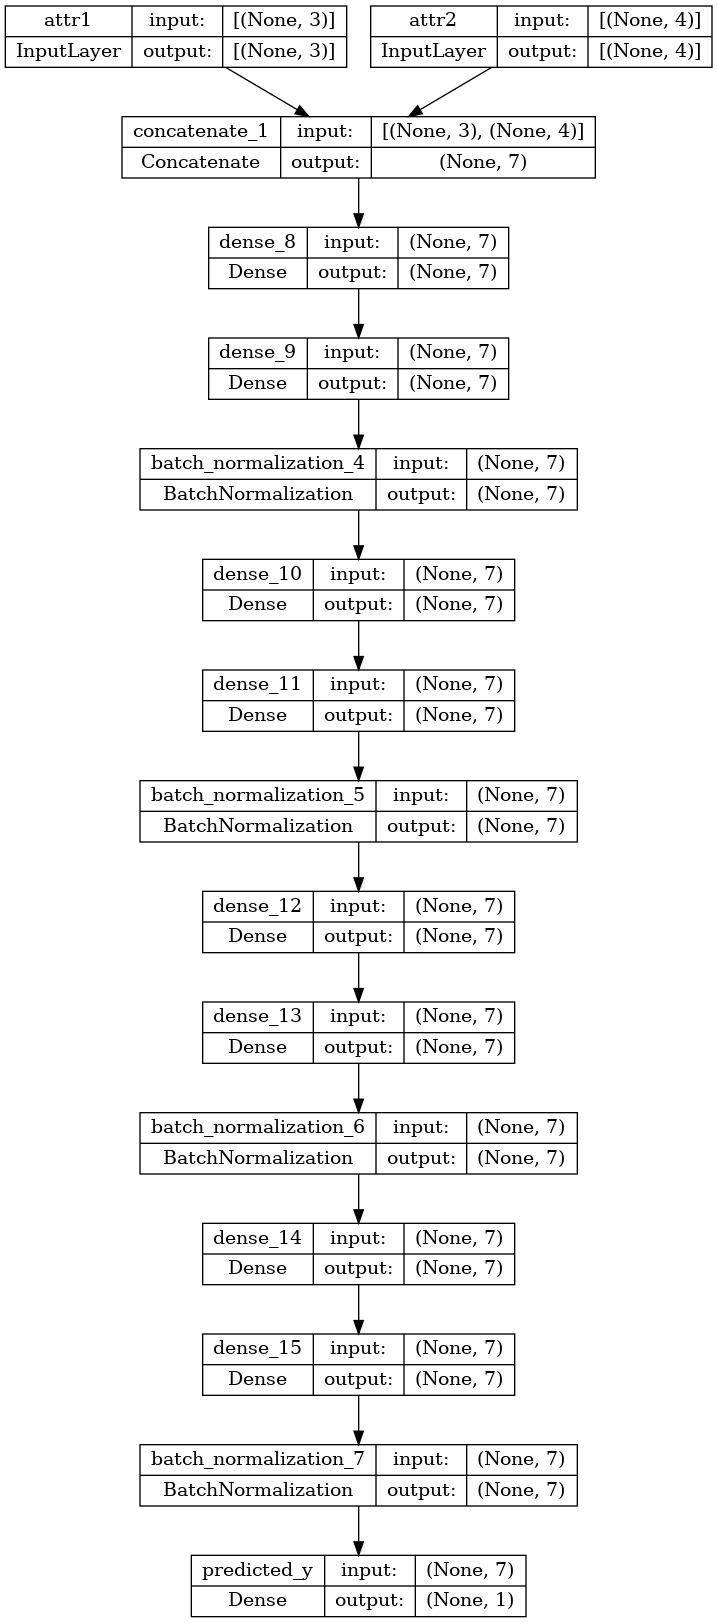

In [52]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [53]:
# Train the model with validation
early_stopping = EarlyStopping(monitor='loss', patience=40, verbose=1)
model.fit({'attr1': attr1_train, 'attr2': attr2_train}, y_true_train, epochs=1000, batch_size=1024, callbacks=[early_stopping], validation_split=0.2)

Epoch 1/1000
3/3 [==============================] - 2s 75ms/step - loss: 9.6736 - val_loss: 16.9385
Epoch 2/1000
3/3 [==============================] - 0s 11ms/step - loss: 5.6836 - val_loss: 16.9188
Epoch 3/1000
3/3 [==============================] - 0s 16ms/step - loss: 3.8906 - val_loss: 16.8719
Epoch 4/1000
3/3 [==============================] - 0s 18ms/step - loss: 3.0670 - val_loss: 16.8066
Epoch 5/1000
3/3 [==============================] - 0s 15ms/step - loss: 2.5134 - val_loss: 16.7316
Epoch 6/1000
3/3 [==============================] - 0s 9ms/step - loss: 2.0268 - val_loss: 16.6462
Epoch 7/1000
3/3 [==============================] - 0s 10ms/step - loss: 1.6975 - val_loss: 16.5483
Epoch 8/1000
3/3 [==============================] - 0s 16ms/step - loss: 1.3482 - val_loss: 16.4487
Epoch 9/1000
3/3 [==============================] - 0s 13ms/step - loss: 1.0941 - val_loss: 16.2421
Epoch 10/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.8390 - val_loss: 16.0074


In [54]:
# Test the model
y_pred_test = model.predict({'attr1': attr1_test, 'attr2': attr2_test})

27/27 [==============================] - 0s 759us/step


In [55]:
err = y_true_test.reshape(-1)-y_pred_test.reshape(-1)

In [56]:
# evaluate the model
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_true_test, y_pred_test))
pd.DataFrame(
    np.stack([y_true_test.reshape(-1), y_pred_test.reshape(-1), np.power(err, 2).reshape(-1)], axis=1),
columns=['y_true', 'y_pred', 'mse']).head(100)

0.41454715


,y_true,y_pred,mse
0,-11.949515,-12.783025,0.694738
1,2.932204,3.210140,0.077248
2,-1.664737,-2.021347,0.127171
3,3.640304,3.545614,0.008966
4,3.264165,3.236907,0.000743
...,...,...,...
95,2.498791,2.428855,0.004891
96,3.354602,3.546321,0.036756
97,-0.450867,-0.846738,0.156713
98,-6.676960,-7.423625,0.557507


In [57]:
attr2

array([[0.514 , 0.2245, 0.101 , 0.15  ],
       [0.2255, 0.0995, 0.0485, 0.07  ],
       [0.677 , 0.2565, 0.1415, 0.21  ],
       ...,
       [1.176 , 0.5255, 0.2875, 0.308 ],
       [1.0945, 0.531 , 0.261 , 0.296 ],
       [1.9485, 0.9455, 0.3765, 0.495 ]], dtype=float32)

In [58]:
# watch values around the theoretical minimum of attr2
a1 = ((attr1.min(axis=0) + attr1.max(axis=0)) *0.5).reshape(1, -1).repeat(100, axis=0)
values = []
for i in range(attr2_dimension):
    a2 = np.array([[1.3, 0.7, 0.4, 0.5,]]).repeat(100, axis=0)
    a2[:, i] += (attr2.max(axis=0)[i] - attr2.min(axis=0)[i]) * np.linspace(-0.5, 0.5, 100)
    v_pred = model.predict({'attr1': a1, 'attr2': a2})
    v_true = real_objective(a1, a2)
    for j in range(100):
        values.append({'dim': i, 'v': a2[j, i], 'y_pred': v_pred[j, 0], 'y_true': v_true[j]})

4/4 [==============================] - 0s 823us/step


In [59]:
values_df = pd.DataFrame(values)
values_df

,dim,v,y_pred,y_true
0,0,-0.111750,0.284049,-17.049204
1,0,-0.083230,0.303754,-15.425235
2,0,-0.054710,0.324557,-13.896278
3,0,-0.026189,0.345359,-12.458521
4,0,0.002331,0.366163,-11.108234
...,...,...,...,...
395,3,0.961205,2.688393,2.474930
396,3,0.971341,2.688393,2.399309
397,3,0.981477,2.688393,2.322044
398,3,0.991614,2.688393,2.243135


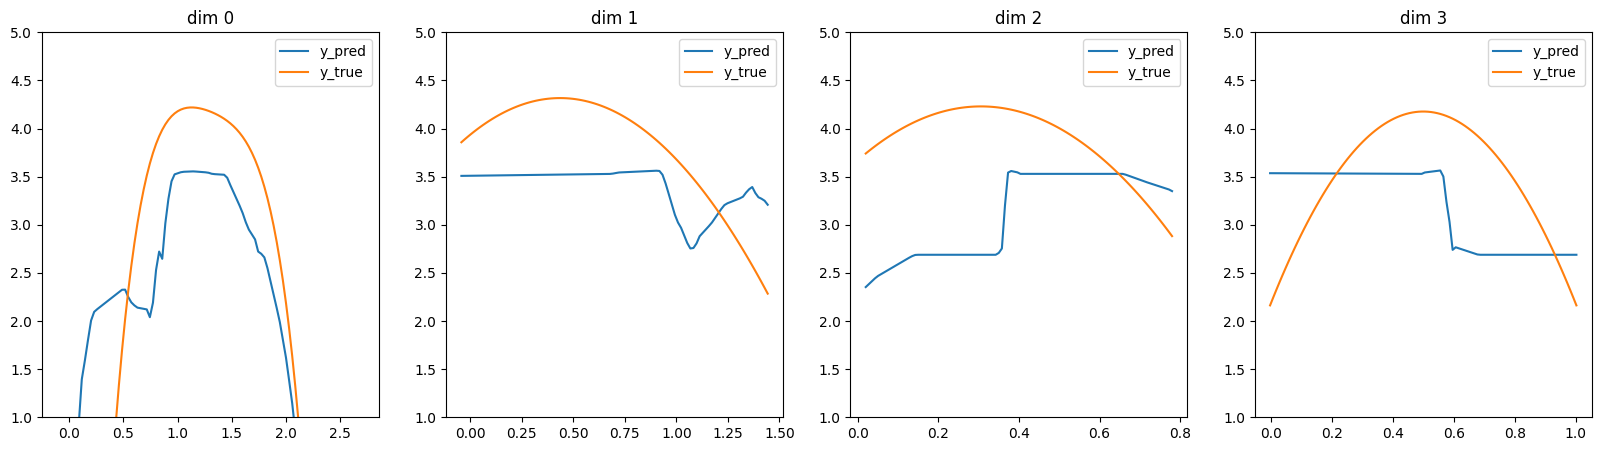

In [60]:
# plot values around the theoretical minimum of attr2 for each dimension
fig, ax = plt.subplots(ncols=attr2_dimension, figsize=(20, 5))
for i in range(attr2_dimension):
    ax[i].plot(values_df[values_df['dim']==i]['v'], values_df[values_df['dim']==i]['y_pred'], label='y_pred')
    ax[i].plot(values_df[values_df['dim']==i]['v'], values_df[values_df['dim']==i]['y_true'], label='y_true')
    ax[i].set_title(f'dim {i}')
    ax[i].set_ylim([1, 5])
    ax[i].legend()

In [61]:
# Given attr1, find attr2 such that the objective function is maximized
# with gradient ascent for the final layer

In [62]:
layer = model.get_layer(name='predicted_y')
feature_extractor = Model(inputs=model.inputs, outputs=layer.output)

def compute_loss(inputs):
    activation = feature_extractor(inputs)
    # We avoid border artifacts by only involving non-border pixels in the loss.
    return tf.reduce_mean(activation)

@tf.function
def gradient_ascent_step(input_attr1, input_attr2, learning_rate):
    inputs = {'attr1': input_attr1, 'attr2': input_attr2}
    with tf.GradientTape() as tape:
        tape.watch(inputs)
        loss = feature_extractor(inputs)
    # Compute gradients.
    _grads = tape.gradient(loss, input_attr2)
    # Normalize gradients.
    grads = tf.math.l2_normalize(_grads)
    input_attr2 += learning_rate * grads
    # clip the values of input_attr2 to the range of attr2
    input_attr2 = tf.clip_by_value(input_attr2, attr2_min, attr2_max)
    return loss, input_attr2, grads, _grads

In [63]:
# constraint of attr2 by the observed min and max values
attr2_min = np.min(attr2, axis=0)
attr2_max = np.max(attr2, axis=0)

In [64]:
def visualize_attr2(input_attr1, input_attr2, epochs, steps_per_epoch, learning_rate):
    if input_attr2 is None:
        # assign random values to input_attr2
        # input_attr2 = tf.random.uniform(shape=(input_attr1.shape[0], attr2_dimension))
        # assign 0.5 to input_attr2
        # input_attr2 = tf.ones(shape=(input_attr1.shape[0], attr2_dimension))*0.5
        input_attr2 = tf.constant([[1.3, 0.7, 0.4, 0.5] for _ in range(input_attr1.shape[0])])
    # plot the loss each step
    for epoch in range(epochs):
        with tqdm(total=steps_per_epoch) as pbar:
            for step in range(steps_per_epoch):
                loss, input_attr2, ngrad, grads = gradient_ascent_step(input_attr1, input_attr2, learning_rate)
                avg_loss = tf.reduce_mean(loss)
                pbar.desc = "[Epoch %d/%d]Loss at step %d: %.2f" % (epoch, epochs, step, avg_loss)
                pbar.update(1)

    return loss, input_attr2, ngrad, grads

# # try run one gradient ascent step
# input_attr2 = tf.random.uniform(shape=(1, attr2_dimension))
# loss, x, grad = gradient_ascent_step(attr1_test[:1], input_attr2, 0.01)
# # clip the values of x to the range of attr2
# x = tf.clip_by_value(x, attr2_min, attr2_max)

In [65]:
loss, estimated_attr2, ngrad, grads = visualize_attr2(attr1_test[:1], None, epochs=10, steps_per_epoch=100, learning_rate=0.01)
display(grads)
display(estimated_attr2)

[Epoch 9/10]Loss at step 99: 3.54: 100%|##########| 100/100 [00:00<00:00, 882.13it/s]


<tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 2.720335 , -0.4438674,  2.6954584,  1.0794913]], dtype=float32)>

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[1.0214564 , 0.6587202 , 0.32333687, 0.48523998]], dtype=float32)>

In [66]:
loss, estimated_attr2, ngrad, grads = visualize_attr2(attr1_test[2:3], None, epochs=10, steps_per_epoch=100, learning_rate=0.01)
display(grads)
display(estimated_attr2)

[Epoch 9/10]Loss at step 99: 3.55: 100%|##########| 100/100 [00:00<00:00, 893.88it/s]


<tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-0.05501751, -0.00105886, -0.02431553, -0.01607947]],
      dtype=float32)>

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0.88643813, 0.8882056 , 0.4272477 , 0.42060715]], dtype=float32)>

In [74]:
loss, estimated_attr2, ngrad, grads = visualize_attr2(attr1_test, None, epochs=10, steps_per_epoch=100, learning_rate=0.01)
display(grads)
display(estimated_attr2)

[Epoch 9/10]Loss at step 99: 3.54: 100%|##########| 100/100 [00:00<00:00, 640.19it/s]


<tf.Tensor: shape=(836, 4), dtype=float32, numpy=
array([[ 1.0517542e-02,  2.5295889e-02, -4.5152292e-02, -6.3655023e-03],
       [-1.6660929e-02,  6.6132210e-03,  6.0239559e-05, -3.4029980e-03],
       [-1.6660929e-02,  6.6132210e-03,  6.0239559e-05, -3.4029980e-03],
       ...,
       [-1.6660929e-02,  6.6132210e-03,  6.0239559e-05, -3.4029980e-03],
       [-1.6660929e-02,  6.6132210e-03,  6.0239559e-05, -3.4029980e-03],
       [-1.6660929e-02,  6.6132210e-03,  6.0239559e-05, -3.4029980e-03]],
      dtype=float32)>

<tf.Tensor: shape=(836, 4), dtype=float32, numpy=
array([[1.1241584 , 0.651844  , 0.4030385 , 0.5169994 ],
       [1.2630323 , 0.71467423, 0.40013352, 0.49244937],
       [1.2630323 , 0.71467423, 0.40013352, 0.49244937],
       ...,
       [1.2630323 , 0.71467423, 0.40013352, 0.49244937],
       [1.2630323 , 0.71467423, 0.40013352, 0.49244937],
       [1.2630323 , 0.71467423, 0.40013352, 0.49244937]], dtype=float32)>

In [76]:
pd.DataFrame(
    estimated_attr2.numpy()
)

,0,1,2,3
0,1.124158,0.651844,0.403039,0.516999
1,1.263032,0.714674,0.400134,0.492449
2,1.263032,0.714674,0.400134,0.492449
3,1.263032,0.714674,0.400134,0.492449
4,1.263032,0.714674,0.400134,0.492449
...,...,...,...,...
831,1.263032,0.714674,0.400134,0.492449
832,1.263032,0.714674,0.400134,0.492449
833,1.263032,0.714674,0.400134,0.492449
834,1.263032,0.714674,0.400134,0.492449


In [69]:
# should be [1.3, 0.7, 0.4, 0.5]
estimated_attr2

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0.88643813, 0.8882056 , 0.4272477 , 0.42060715]], dtype=float32)>

In [70]:
estimated_attr2

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0.88643813, 0.8882056 , 0.4272477 , 0.42060715]], dtype=float32)>

In [71]:
# make x tf tensor with value [1.3, 0.7, 0.4, 0.5]
x = tf.Variable([1.3, 0.7, 0.4, 0.5])

In [72]:
x

<tf.Variable 'Variable:0' shape=(4,) dtype=float32, numpy=array([1.3, 0.7, 0.4, 0.5], dtype=float32)>